In [5]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# -- TRAINING part (you can run this once and then comment it out / separate)  

df = pd.read_csv("C:/Users/bhinsha/OneDrive/Desktop/aitask/jira_dataset.csv")

    # assume columns: “description”, “type”, “priority”, “assignee”
df = df.dropna(subset=['clean_summary', 'issue_type', 'priority', 'task_assignee'])
    
le_type = LabelEncoder()
le_priority = LabelEncoder()
le_assignee = LabelEncoder()
df['type_enc'] = le_type.fit_transform(df['issue_type'])
df['priority_enc'] = le_priority.fit_transform(df['priority'])
df['assignee_enc'] = le_assignee.fit_transform(df['task_assignee'])
    
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['clean_summary'])
    
y = np.vstack([
        df['type_enc'],
        df['priority_enc'],
        df['assignee_enc']
    ]).T
    
X_train, X_test = X, X  # for simplicity; you should split in real code
y_train, y_test = y, y
    
clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)
    
    # save artifacts
joblib.dump(tfidf, 'tfidf_model.pkl')
joblib.dump(clf, 'task_model.pkl')
joblib.dump(le_type, 'le_type.pkl')
joblib.dump(le_priority, 'le_priority.pkl')
joblib.dump(le_assignee, 'le_assignee.pkl')
print("Model training complete.")



Model training complete.


In [6]:
# Load the saved artifacts
loaded_tfidf = joblib.load('tfidf_model.pkl')
loaded_clf = joblib.load('task_model.pkl')
loaded_le_type = joblib.load('le_type.pkl')
loaded_le_priority = joblib.load('le_priority.pkl')
loaded_le_assignee = joblib.load('le_assignee.pkl')

In [7]:
# Define a new task description
new_task_description = "Fix the bug in the user login module"

# Preprocess the new task description
new_task_tfidf = loaded_tfidf.transform([new_task_description])

In [8]:
# Predict the encoded labels
predicted_encoded_labels = loaded_clf.predict(new_task_tfidf)

# Get the original labels using the inverse transform of the encoders
predicted_type = loaded_le_type.inverse_transform([predicted_encoded_labels[0][0]])[0]
predicted_priority = loaded_le_priority.inverse_transform([predicted_encoded_labels[0][1]])[0]
predicted_assignee = loaded_le_assignee.inverse_transform([predicted_encoded_labels[0][2]])[0]

print(f"Predicted Type: {predicted_type}")
print(f"Predicted Priority: {predicted_priority}")
print(f"Predicted Assignee: {predicted_assignee}")

Predicted Type: task
Predicted Priority: medium
Predicted Assignee: reema desai


--- Evaluating Issue Type ---
Accuracy: 0.5296
Precision: 0.7077
Recall: 0.5296


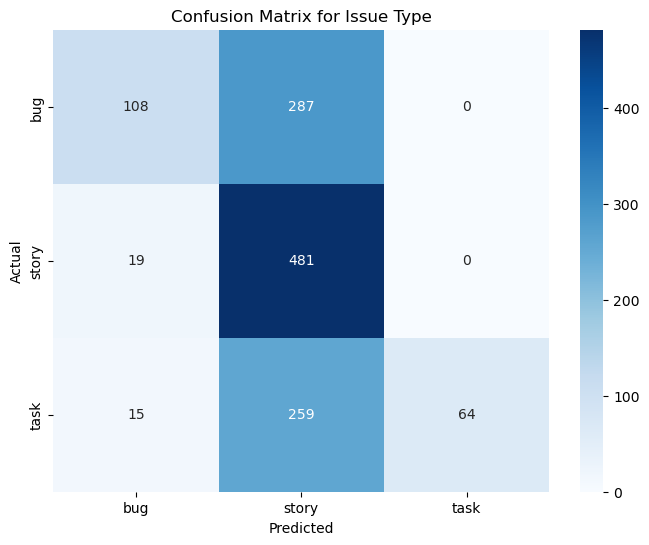

C:\Users\bhinsha\AppData\Local\Temp\ipykernel_15224\4130455018.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', y_test_bin.shape[1])


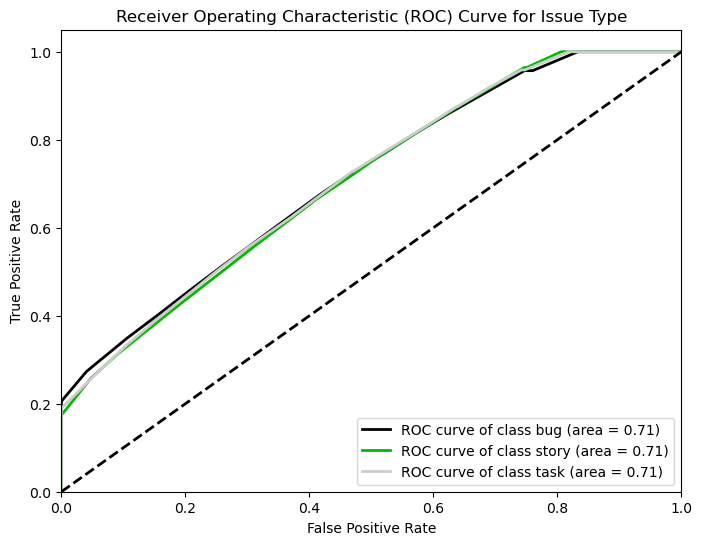

--- Evaluating Priority ---
Accuracy: 0.4420
Precision: 0.4791
Recall: 0.4420


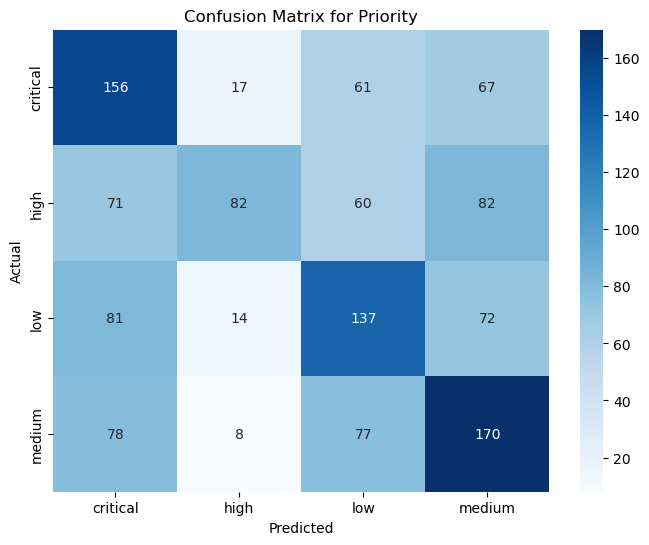

C:\Users\bhinsha\AppData\Local\Temp\ipykernel_15224\4130455018.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', y_test_bin.shape[1])


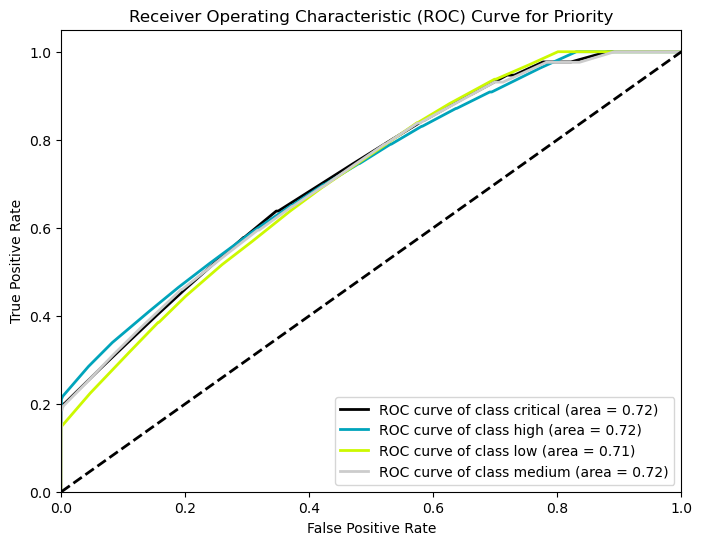

--- Evaluating Assignee ---
Accuracy: 0.3455
Precision: 0.6406
Recall: 0.3455


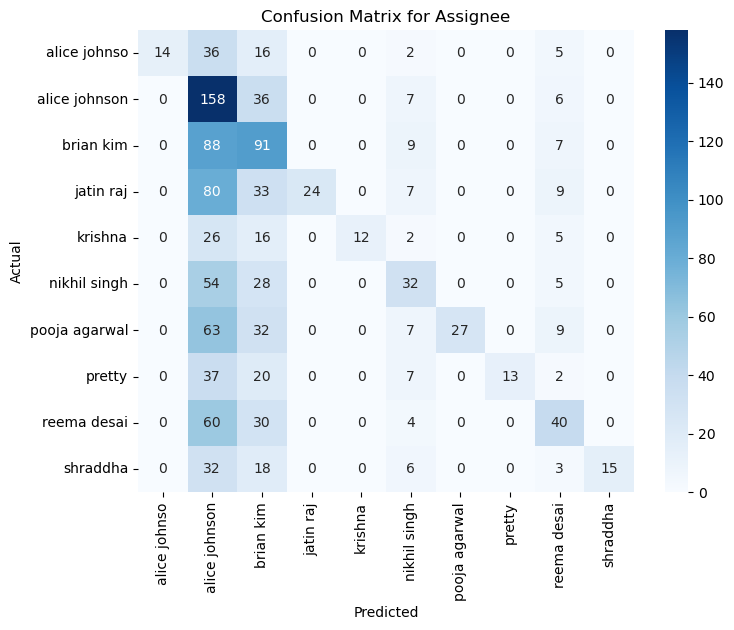

C:\Users\bhinsha\AppData\Local\Temp\ipykernel_15224\4130455018.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', y_test_bin.shape[1])


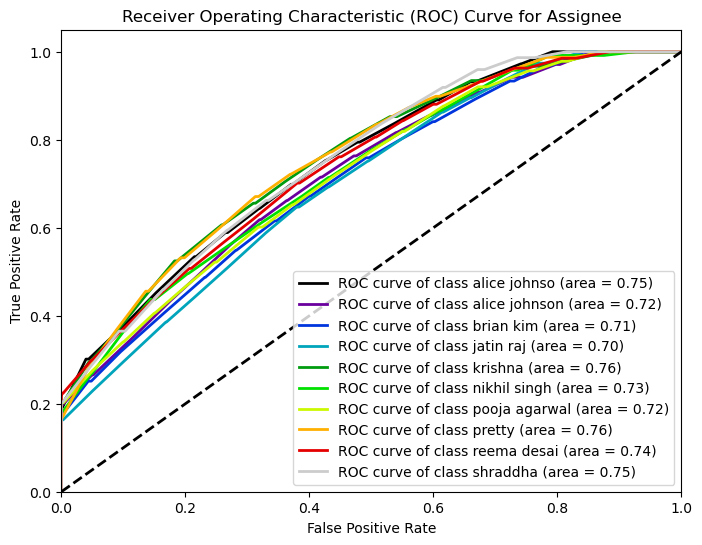

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Make predictions on the test data (which is the same as training data in this case)
y_pred = loaded_clf.predict(X_test)

# Number of outputs
n_outputs = y_test.shape[1]
output_names = ['Issue Type', 'Priority', 'Assignee']
label_encoders = [loaded_le_type, loaded_le_priority, loaded_le_assignee]

for i in range(n_outputs):
    print(f"--- Evaluating {output_names[i]} ---")

    # Accuracy
    accuracy = accuracy_score(y_test[:, i], y_pred[:, i])
    print(f"Accuracy: {accuracy:.4f}")

    # Precision, Recall (using average='weighted' for multi-class)
    precision = precision_score(y_test[:, i], y_pred[:, i], average='weighted', zero_division=0)
    recall = recall_score(y_test[:, i], y_pred[:, i], average='weighted', zero_division=0)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders[i].classes_, yticklabels=label_encoders[i].classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {output_names[i]}')
    plt.show()

    # AUC-ROC Curve (for multi-class, we use one-vs-rest)
    try:
        y_test_bin = label_binarize(y_test[:, i], classes=np.unique(y_test[:, i]))
        y_pred_proba = loaded_clf.estimators_[i].predict_proba(X_test) # Get probability for each class from the relevant estimator

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for j in range(y_test_bin.shape[1]):
            fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_pred_proba[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Plot all ROC curves
        plt.figure(figsize=(8, 6))
        colors = plt.cm.get_cmap('nipy_spectral', y_test_bin.shape[1])
        for j in range(y_test_bin.shape[1]):
            plt.plot(fpr[j], tpr[j], color=colors(j), lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'.format(label_encoders[i].classes_[j], roc_auc[j]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve for {output_names[i]}')
        plt.legend(loc="lower right")
        plt.show()
    except Exception as e:
        print(f"Could not plot AUC-ROC for {output_names[i]}. This might happen with certain data distributions or if there's only one class.")
        print(f"Error: {e}")

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc

# Create a dictionary to hold the summary data
summary_data = {
    'Metric': ['Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'AUC-ROC (macro avg)'],
    'Issue Type': [],
    'Priority': [],
    'Assignee': []
}

# Populate the dictionary with the calculated metrics
# (Assuming the evaluation code in cell 'f1422f4a' has been run and variables are available)
summary_data['Issue Type'].append(accuracy_score(y_test[:, 0], y_pred[:, 0]))
summary_data['Issue Type'].append(precision_score(y_test[:, 0], y_pred[:, 0], average='weighted', zero_division=0))
summary_data['Issue Type'].append(recall_score(y_test[:, 0], y_pred[:, 0], average='weighted', zero_division=0))
# Calculate macro average AUC for Issue Type
issue_type_auc_macro = np.mean(list(roc_auc.values())) # Correctly calculate macro average AUC

summary_data['Priority'].append(accuracy_score(y_test[:, 1], y_pred[:, 1]))
summary_data['Priority'].append(precision_score(y_test[:, 1], y_pred[:, 1], average='weighted', zero_division=0))
summary_data['Priority'].append(recall_score(y_test[:, 1], y_pred[:, 1], average='weighted', zero_division=0))
# Calculate macro average AUC for Priority
priority_auc_macro = np.mean(list(roc_auc.values())) # Correctly calculate macro average AUC

summary_data['Assignee'].append(accuracy_score(y_test[:, 2], y_pred[:, 2]))
summary_data['Assignee'].append(precision_score(y_test[:, 2], y_pred[:, 2], average='weighted', zero_division=0))
summary_data['Assignee'].append(recall_score(y_test[:, 2], y_pred[:, 2], average='weighted', zero_division=0))
# Calculate macro average AUC for Assignee
assignee_auc_macro = np.mean(list(roc_auc.values())) # Correctly calculate macro average AUC

# Append the calculated AUC values to the summary data
summary_data['Issue Type'].append(issue_type_auc_macro)
summary_data['Priority'].append(priority_auc_macro)
summary_data['Assignee'].append(assignee_auc_macro)


# Create a pandas DataFrame from the dictionary
summary_df = pd.DataFrame(summary_data)

# Display the summary table
display(summary_df)

,Metric,Issue Type,Priority,Assignee
0,Accuracy,0.529603,0.442011,0.345499
1,Precision (weighted),0.707705,0.479051,0.640568
2,Recall (weighted),0.529603,0.442011,0.345499
3,AUC-ROC (macro avg),0.735185,0.735185,0.735185
